In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [54]:
file_path = "../data/Red Bull Case Study Data.xlsx"

df = pd.read_excel(file_path, engine="openpyxl")

In [55]:
print("hi")

hi


**Preprocessing**

Repeat steps from EDA

In [56]:
df["H4 Prd Variant"] = df["H4 Prd Variant"].replace(
    "Red Bull Watermlon Edition",
    "Red Bull Watermelon Edition"
)
df = df[df["Calendar Day"].dt.year >= 2018]

customer_cols = ["Customer A", "Customer B", "Customer C"]
df["Customer Total"] = df[customer_cols].sum(axis=1, skipna=True)

# If ALL customers are NaN → set total to NaN
all_nan_mask = df[customer_cols].isna().all(axis=1)
df.loc[all_nan_mask, "Customer Total"] = pd.NA

df["product_id"] = (
    df["H4 Prd Variant"] + " | "
    + df["H5 Prd Filling size"] + " | "
    + df["H7 Prd Pckg Unit"]
)
df=df.drop(columns=['H4 Prd Variant','H5 Prd Filling size','H7 Prd Pckg Unit'])

df = df.melt(
    id_vars=["Calendar Day", "product_id"],
    value_vars=["Customer A", "Customer B", "Customer C","Customer Total"],
    var_name="customer",
    value_name="demand"
)

df = df.drop_duplicates(
    subset=["Calendar Day", "product_id", "customer"],
    keep="first"
)


Exclude Products Red Bull Watermelon Edition | 355ml/12oz | Single and Red Bull Yellow Edition | 250ml/8.4oz | Single

In [57]:
products_to_drop = [
    "Red Bull Watermelon Edition | 355ml/12oz | Single",
    "Red Bull Yellow Edition | 250ml/8.4oz | Single",
]

df = df[~df["product_id"].isin(products_to_drop)]

Aggregate Weekly

In [58]:
df_weekly = (
    df
    .set_index("Calendar Day")
    .groupby(["product_id", "customer"])
    .resample("W")["demand"]
    .sum(min_count=1) 
    .reset_index()
)
df_weekly.head()

,product_id,customer,Calendar Day,demand
0,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-01-07,13254.0
1,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-01-14,9343.0
2,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-01-21,3586.0
3,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-01-28,36088.0
4,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-02-04,177.0


Add Payday indicator

In [59]:
def add_payday_indicator_simple(df, date_col="Calendar Day"):
    """
    Adds a 'payday' column for weekly data.
    A week is marked as payday if its week-ending date falls between the 3rd and 8th of the month.
    
    Assumes df[date_col] is the week-ending date.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Payday week if day of month is between 3 and 9
    df["payday"] = df[date_col].dt.day.between(3, 9).astype(int)
    
    return df

df_weekly = add_payday_indicator_simple(df_weekly, date_col="Calendar Day")

**Model**

In [60]:
def fit_dynamic_regression(
    df,
    train_period,
    val_period,
    product_id,
    customer="Customer Total",
    fourier_terms=None,
    trend_order=1,
    arma_order=(0, 0),
    d=0,  # <-- add differencing order here (0 or 1 typically)
    payday_indicator=True,
    y_transform=None,   # None, "log", "sqrt"
    ci_level=0.80,      # 80% CI by default
):
    """
    Fit dynamic regression (exog + ARIMA errors via SARIMAX), forecast validation,
    and compute coverage + RMSE metrics.

    Returns:
      - train/val dfs
      - X_train/X_val (including Calendar Day & week_number)
      - fitted model
      - forecast mean + 80% CI
      - coverage and RMSE metrics
    """

    # --- 0) Build modeling frame ---
    cols = ["Calendar Day", "demand"]
    if payday_indicator:
        cols.append("payday")  # must exist in df if payday_indicator=True

    df_model = df.loc[
        (df["product_id"] == product_id) &
        (df["customer"] == customer),
        cols
    ].copy()

    df_model.sort_values("Calendar Day", inplace=True)
    df_model.reset_index(drop=True, inplace=True)

    df_model["week_number"] = df_model["Calendar Day"].dt.isocalendar().week.astype(int)

    # Transform y for modeling if requested
    if y_transform == "log":
        # guard against non-positive
        if (df_model["demand"] <= 0).any():
            raise ValueError("y_transform='log' requires demand > 0 for all observations.")
        df_model["y_model"] = np.log(df_model["demand"])
    elif y_transform == "sqrt":
        if (df_model["demand"] < 0).any():
            raise ValueError("y_transform='sqrt' requires demand >= 0 for all observations.")
        df_model["y_model"] = np.sqrt(df_model["demand"])
    else:
        df_model["y_model"] = df_model["demand"].astype(float)

    # --- 1) Train/val split ---
    train_mask = (df_model["Calendar Day"] >= train_period[0]) & (df_model["Calendar Day"] <= train_period[1])
    val_mask   = (df_model["Calendar Day"] >= val_period[0])   & (df_model["Calendar Day"] <= val_period[1])

    train_df = df_model.loc[train_mask].copy()
    val_df   = df_model.loc[val_mask].copy()

    # Set Date index for clean alignment
    train_df = train_df.set_index("Calendar Day")
    val_df   = val_df.set_index("Calendar Day")

    y_train = train_df["y_model"]
    y_val_actual = val_df["demand"]  # evaluate on original scale

    # --- 2) Build X matrices (keep Calendar Day implicit via index) ---
    X_train = pd.DataFrame(index=train_df.index)
    X_val   = pd.DataFrame(index=val_df.index)

    X_train["week_number"] = train_df["week_number"].astype(int)
    X_val["week_number"]   = val_df["week_number"].astype(int)

    if payday_indicator:
        X_train["payday"] = train_df["payday"].astype(float)
        X_val["payday"]   = val_df["payday"].astype(float)

    # Trend terms
    t0 = np.arange(len(train_df), dtype=float)
    t1 = np.arange(len(train_df), len(train_df) + len(val_df), dtype=float)

    for i in range(1, trend_order + 1):
        X_train[f"trend_{i}"] = t0 ** i
        X_val[f"trend_{i}"]   = t1 ** i

    # Fourier seasonality using week_number
    if fourier_terms is not None and fourier_terms > 0:
        period = 52.0
        for k in range(1, fourier_terms + 1):
            X_train[f"sin_{k}"] = np.sin(2 * np.pi * k * X_train["week_number"] / period)
            X_train[f"cos_{k}"] = np.cos(2 * np.pi * k * X_train["week_number"] / period)
            X_val[f"sin_{k}"]   = np.sin(2 * np.pi * k * X_val["week_number"] / period)
            X_val[f"cos_{k}"]   = np.cos(2 * np.pi * k * X_val["week_number"] / period)

    # Exog passed to SARIMAX: drop week_number if you don't want it directly (you currently do)
    exog_cols = [c for c in X_train.columns if c != "week_number"]
    X_train_exog = X_train[exog_cols].astype(float)
    X_val_exog   = X_val[exog_cols].astype(float)

    # --- 3) Fit SARIMAX ---
    sarimax_model = SARIMAX(
        y_train,
        exog=X_train_exog,
        order=(arma_order[0], d, arma_order[1]),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarimax_fit = sarimax_model.fit(disp=False)

    # --- 4) Forecast validation period (mean + CI on model scale) ---
    steps = len(val_df)
    fcst = sarimax_fit.get_forecast(steps=steps, exog=X_val_exog)

    fcst_mean_model = fcst.predicted_mean
    alpha = 1.0 - ci_level
    fcst_ci_model = fcst.conf_int(alpha=alpha)  # columns like 'lower y', 'upper y' (here likely 'lower demand' etc.)

    # Normalize CI column names safely
    lo_col = [c for c in fcst_ci_model.columns if "lower" in c.lower()][0]
    hi_col = [c for c in fcst_ci_model.columns if "upper" in c.lower()][0]

    # --- 5) Back-transform forecasts to original scale for evaluation ---
    def inv_transform(x: pd.Series) -> pd.Series:
        if y_transform == "log":
            return np.exp(x)
        elif y_transform == "sqrt":
            return np.square(x)
        else:
            return x

    fcst_mean = inv_transform(fcst_mean_model)
    fcst_lo   = inv_transform(fcst_ci_model[lo_col])
    fcst_hi   = inv_transform(fcst_ci_model[hi_col])

    # Align indices (should already match val_df index)
    fcst_mean = fcst_mean.reindex(val_df.index)
    fcst_lo   = fcst_lo.reindex(val_df.index)
    fcst_hi   = fcst_hi.reindex(val_df.index)

    # --- 6) Metrics ---
    inside_80 = (y_val_actual >= fcst_lo) & (y_val_actual <= fcst_hi)
    coverage_80 = float(inside_80.mean())

    rmse = float(np.sqrt(np.mean((fcst_mean - y_val_actual) ** 2)))
    actual_mean = float(y_val_actual.mean())
    rmse_rel_mean = float(rmse / actual_mean) if actual_mean != 0 else np.nan

    # Residuals on training (model scale)
    train_pred = sarimax_fit.get_prediction(start=y_train.index[0], end=y_train.index[-1]).predicted_mean
    residuals_model = y_train - train_pred

    return {
        "model": sarimax_fit,
        "train_df": train_df,
        "val_df": val_df,
        "X_train": X_train,
        "X_val": X_val,
        "y_train": y_train,
        "y_val": y_val_actual,
        "model_fit": sarimax_fit,
        "customer": customer,
        "product_id": product_id,

        "train_pred_model": train_pred,
        "residuals_model": residuals_model,

        "forecast_mean": fcst_mean,
        "forecast_ci": pd.DataFrame({"lower": fcst_lo, "upper": fcst_hi}, index=val_df.index),

        "metrics": {
            "coverage_80": coverage_80,
            "rmse": rmse,
            "rmse_rel_mean": rmse_rel_mean,
        }
    }


Plot Model on Train and Validation

In [61]:
def plot_sarimax_fit_forecast(sarimax_fit, y_train, y_val, customer, product_id, X_train=None, X_val=None,alpha=0.2):
    """
    Plots SARIMAX in-sample fit and out-of-sample forecast.
    
    sarimax_fit: fitted SARIMAX model
    y_train: pandas Series, training endogenous
    y_val: pandas Series, validation endogenous
    X_train: pandas DataFrame of exogenous regressors for training (optional)
    X_val: pandas DataFrame of exogenous regressors for validation (optional)
    alpha: float, 1 - CI level (0.2 = 80% CI)
    """
    # --- 1. In-sample prediction on training data ---
    train_pred = sarimax_fit.get_prediction(start=0, end=len(y_train)-1)
    train_pred_mean = train_pred.predicted_mean
    train_pred_ci = train_pred.conf_int(alpha=alpha)

    # --- 2. Out-of-sample forecast for validation period ---
    forecast = sarimax_fit.get_forecast(steps=len(y_val), exog=X_val)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=alpha)

    # --- 3. Plot ---
    plt.figure(figsize=(14,6))

    # Training data actual and fit
    plt.plot(y_train.index, y_train, label="Train Actual", color="blue")
    plt.plot(y_train.index, train_pred_mean, label="Train Fit", color="orange")
    #plt.fill_between(y_train.index, train_pred_ci.iloc[:,0], train_pred_ci.iloc[:,1],
                    # color="orange", alpha=0.2)

    # Validation data actual and forecast
    plt.plot(y_val.index, y_val, label="Validation Actual", color="green")
    plt.plot(y_val.index, forecast_mean, label="Forecast", color="red")
    plt.fill_between(y_val.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1],
                     color="red", alpha=0.2)

    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.title(f"SARIMAX Fit and Forecast {customer} and {product_id}")
    plt.legend()
    plt.show()


In [62]:
def plot_sarimax_fit_forecast(
    sarimax_fit,
    y_train,
    y_val,
    customer,
    product_id,
    X_train=None,
    X_val=None,
    alpha=0.2,
    start_date=None,   # NEW ARGUMENT
):
    """
    Plots SARIMAX in-sample fit and out-of-sample forecast.

    start_date: optional datetime or string. Only dates >= start_date are plotted.
    """

    import pandas as pd
    import matplotlib.pyplot as plt

    # --- 1. In-sample prediction ---
    train_pred = sarimax_fit.get_prediction(start=0, end=len(y_train)-1)
    train_pred_mean = train_pred.predicted_mean
    train_pred_ci = train_pred.conf_int(alpha=alpha)

    # --- 2. Out-of-sample forecast ---
    forecast = sarimax_fit.get_forecast(steps=len(y_val), exog=X_val)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=alpha)

    # --- 3. Apply start_date filter if provided ---
    if start_date is not None:

        start_date = pd.to_datetime(start_date)

        y_train_plot = y_train[y_train.index >= start_date]
        train_pred_mean_plot = train_pred_mean[train_pred_mean.index >= start_date]

        y_val_plot = y_val[y_val.index >= start_date]
        forecast_mean_plot = forecast_mean[forecast_mean.index >= start_date]
        forecast_ci_plot = forecast_ci[forecast_ci.index >= start_date]

    else:

        y_train_plot = y_train
        train_pred_mean_plot = train_pred_mean

        y_val_plot = y_val
        forecast_mean_plot = forecast_mean
        forecast_ci_plot = forecast_ci

    # --- 4. Plot ---
    plt.figure(figsize=(14,6))

    plt.plot(y_train_plot.index, y_train_plot, label="Train Actual", color="blue")
    plt.plot(train_pred_mean_plot.index, train_pred_mean_plot, label="Train Fit", color="orange")

    plt.plot(y_val_plot.index, y_val_plot, label="Test Actual", color="green")
    plt.plot(forecast_mean_plot.index, forecast_mean_plot, label="Forecast", color="red")

    plt.fill_between(
        forecast_ci_plot.index,
        forecast_ci_plot.iloc[:,0],
        forecast_ci_plot.iloc[:,1],
        color="red",
        alpha=0.2
    )

    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.title(f"SARIMAX Fit and Forecast {customer} and {product_id}")
    plt.legend()
    plt.show()


In [63]:
df_weekly['product_id'].unique()

<StringArray>
[      'Red Bull Blue Edition | 250ml/8.4oz | Single',
        'Red Bull Energy Drink | 250ml/8.4oz | 4Pack',
       'Red Bull Energy Drink | 250ml/8.4oz | Single',
        'Red Bull Energy Drink | 355ml/12oz | Single',
 'Red Bull Watermelon Edition | 250ml/8.4oz | Single']
Length: 5, dtype: str

/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


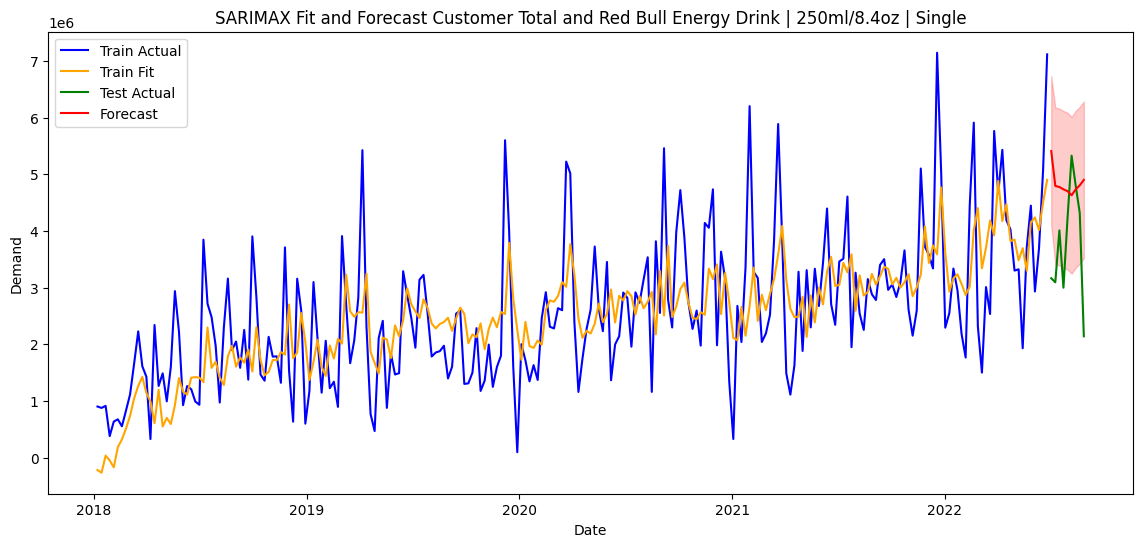

In [64]:
result = fit_dynamic_regression(
    df=df_weekly,                              # your full dataframe
    train_period=("2018-01-01", "2022-06-30"),
    val_period=("2022-07-01", "2022-08-31"),
    product_id="Red Bull Energy Drink | 250ml/8.4oz | Single",
    customer="Customer Total",

    fourier_terms=4,                    # seasonality flexibility
    trend_order=3,                      # polynomial trend
    arma_order=(1, 1),                  # ARMA(p,q)
    d=0,                                # differencing
    payday_indicator=True,

    y_transform=None,                   # or "log"
    ci_level=0.80                       # 80% CI
)

# Plot
plot_sarimax_fit_forecast(
    sarimax_fit=result["model_fit"], 
    y_train=result["y_train"], 
    y_val=result["y_val"],
    product_id=result["product_id"],
    customer=result["customer"], 
    X_train=result["X_train"].drop(columns=["week_number"]).astype(float), 
    X_val=result["X_val"].drop(columns=["week_number"]).astype(float)
)

Grid Search over hyperparameters

In [80]:
import pandas as pd
import numpy as np

def evaluate_model_backtests(
    df,
    product_id,
    customer,
    backtest_origins,
    val_weeks,
    params,
    target_coverage=0.80,
    y_transform=None,
):
    """
    Evaluate one model spec across multiple rolling backtests.

    Returns dict with averaged metrics.
    """

    coverages = []
    widths = []
    rmses_rel = []

    for origin in backtest_origins:

        train_period = (
            df["Calendar Day"].min(),
            pd.to_datetime(origin)
        )

        val_start = pd.to_datetime(origin) + pd.Timedelta(weeks=1)
        val_end = val_start + pd.Timedelta(weeks=val_weeks-1)

        val_period = (val_start, val_end)

        try:
            res = fit_dynamic_regression(
                df=df,
                train_period=train_period,
                val_period=val_period,
                product_id=product_id,
                customer=customer,
                fourier_terms=params["fourier_terms"],
                trend_order=params["trend_order"],
                arma_order=params["arma_order"],
                d=params["d"],
                payday_indicator=params["payday_indicator"],
                y_transform=y_transform,
                ci_level=target_coverage,
            )

            coverage = res["metrics"]["coverage_80"]
            rmse_rel = res["metrics"]["rmse_rel_mean"]

            ci = res["forecast_ci"]
            avg_width = (ci["upper"] - ci["lower"]).mean()

            coverages.append(coverage)
            widths.append(avg_width)
            rmses_rel.append(rmse_rel)

        except Exception:
            return None

    mean_coverage = np.mean(coverages)
    mean_width = np.mean(widths)
    mean_rmse_rel = np.mean(rmses_rel)

    return {
        "coverage": mean_coverage,
        "cov_dev": abs(mean_coverage - target_coverage),
        "avg_ci_width": mean_width,
        "rmse_rel_mean": mean_rmse_rel
    }

import itertools

def grid_search_backtests(
    df,
    product_id,
    customer,
    backtest_origins,
    val_weeks,
    grid,
    target_coverage=0.80,
):
    results = []

    keys = list(grid.keys())
    combos = list(itertools.product(*grid.values()))

    for values in combos:

        params = dict(zip(keys, values))

        metrics = evaluate_model_backtests(
            df=df,
            product_id=product_id,
            customer=customer,
            backtest_origins=backtest_origins,
            val_weeks=val_weeks,
            params=params,
            target_coverage=target_coverage
        )

        if metrics is None:
            continue

        results.append({
            **params,
            **metrics
        })

        print(params, metrics)

    results_df = pd.DataFrame(results)

    results_df = results_df.sort_values(
        by=["cov_dev", "avg_ci_width", "rmse_rel_mean"],
        ascending=[True, True, True]
    ).reset_index(drop=True)

    best_params = results_df.iloc[0][keys].to_dict()

    return best_params, results_df

grid = {
    "fourier_terms": [2,4,6],
    "trend_order": [1,2,3],
    "arma_order": [(0,0),(1,0),(0,1),(1,1)],
    "d": [0,1],
    "payday_indicator": [False,True]
}

backtest_origins = [
    "2021-06-30",
    "2021-12-31",
    "2022-04-30"
]

best_params, results_df = grid_search_backtests(
    df=df_weekly,
    product_id="Red Bull Energy Drink | 355ml/12oz | Single",
    customer="Customer Total",
    backtest_origins=backtest_origins,
    val_weeks=12,
    grid=grid,
    target_coverage=0.80
)

print(best_params)



/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(13638184.607359618), 'rmse_rel_mean': np.float64(0.5750078757772124)}
{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(13427240.30218297), 'rmse_rel_mean': np.float64(0.545583018923533)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24833723.359531615), 'rmse_rel_mean': np.float64(0.22214633258162833)}
{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24578416.675274853), 'rmse_rel_mean': np.float64(0.23264769186997425)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(918379.3646178489), 'rmse_rel_mean': np.float64(0.5016606163946963)}
{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.42424242424242425), 'cov_dev': np.float64(0.3757575757575758), 'avg_ci_width': np.float64(922115.9608844452), 'rmse_rel_mean': np.float64(0.5043442718522613)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(1249864.2542338239), 'rmse_rel_mean': np.float64(0.2089943691875429)}
{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(1247323.9967866493), 'rmse_rel_mean': np.float64(0.21862854401721657)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(1008722.2390516646), 'rmse_rel_mean': np.float64(0.5750078755290248)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.4545454545454546), 'cov_dev': np.float64(0.34545454545454546), 'avg_ci_width': np.float64(972560.7157092037), 'rmse_rel_mean': np.float64(0.5455830187085163)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(621467.4779760035), 'rmse_rel_mean': np.float64(0.20248017472877144)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(616784.3041418499), 'rmse_rel_mean': np.float64(0.20803582868085488)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(636179.5123493663), 'rmse_rel_mean': np.float64(0.3007608732527833)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757577), 'cov_dev': np.float64(0.042424242424242364), 'avg_ci_width': np.float64(686943.2143697996), 'rmse_rel_mean': np.float64(0.28996089827731164)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(622975.9343012378), 'rmse_rel_mean': np.float64(0.20395308373944365)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(616070.4289968763), 'rmse_rel_mean': np.float64(0.20761424916654128)}
{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(9978385.458239814), 'rmse_rel_mean': np.float64(0.3549954834132864)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(9964432.945666688), 'rmse_rel_mean': np.float64(0.3494635400189467)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24833277.978823107), 'rmse_rel_mean': np.float64(0.23089825966850971)}
{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24578085.36641671), 'rmse_rel_mean': np.float64(0.2412621379176446)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(687796.3047373598), 'rmse_rel_mean': np.float64(0.3502582756748364)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(688406.2683160919), 'rmse_rel_mean': np.float64(0.3448432272718847)}
{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(1249751.235693108), 'rmse_rel_mean': np.float64(0.21511885048485482)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(1247218.8007774784), 'rmse_rel_mean': np.float64(0.22499181661079914)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(686052.7640205206), 'rmse_rel_mean': np.float64(0.3542158659696429)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(685059.7316689481), 'rmse_rel_mean': np.float64(0.3486835524984903)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(623419.19111375), 'rmse_rel_mean': np.float64(0.20294748136433274)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(616084.5945425552), 'rmse_rel_mean': np.float64(0.20813895492062742)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(599949.2316999629), 'rmse_rel_mean': np.float64(0.2838888257446483)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(605477.8112385183), 'rmse_rel_mean': np.float64(0.2786019738398023)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(620888.63037288), 'rmse_rel_mean': np.float64(0.20593932004660775)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(613674.9189575188), 'rmse_rel_mean': np.float64(0.2103478074553258)}
{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(8915975.758152224), 'rmse_rel_mean': np.float64(0.3342837351706888)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(8915788.242134942), 'rmse_rel_mean': np.float64(0.33382644143545087)}
{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24833073.327423956), 'rmse_rel_mean': np.float64(0.2391022161236663)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24577736.315039974), 'rmse_rel_mean': np.float64(0.2555165841095495)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(615787.4223908467), 'rmse_rel_mean': np.float64(0.32948727013416695)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(615862.0007785942), 'rmse_rel_mean': np.float64(0.3290799341250686)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(1249755.0612003386), 'rmse_rel_mean': np.float64(0.2175655215234739)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8787878787878788), 'cov_dev': np.float64(0.07878787878787874), 'avg_ci_width': np.float64(1247266.3091189337), 'rmse_rel_mean': np.float64(0.2330335939079732)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(605977.9643072323), 'rmse_rel_mean': np.float64(0.3331074456404561)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(606032.1843867853), 'rmse_rel_mean': np.float64(0.33265784077367816)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(624120.9478338736), 'rmse_rel_mean': np.float64(0.20255403602728986)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.787878787878788), 'cov_dev': np.float64(0.012121212121212088), 'avg_ci_width': np.float64(620469.8559294081), 'rmse_rel_mean': np.float64(0.2182450382333242)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5454545454545455), 'cov_dev': np.float64(0.2545454545454545), 'avg_ci_width': np.float64(575036.8740689292), 'rmse_rel_mean': np.float64(0.29774776640785633)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(575269.2499482915), 'rmse_rel_mean': np.float64(0.297418199863173)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.787878787878788), 'cov_dev': np.float64(0.012121212121212088), 'avg_ci_width': np.float64(622693.8607432164), 'rmse_rel_mean': np.float64(0.21185817431704299)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(615898.6023686206), 'rmse_rel_mean': np.float64(0.2146179535008311)}
{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(13612334.154609175), 'rmse_rel_mean': np.float64(0.5778167937068867)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(13401937.979980357), 'rmse_rel_mean': np.float64(0.5474859162278162)}
{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24805557.40288426), 'rmse_rel_mean': np.float64(0.23852380629876255)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24550596.540063128), 'rmse_rel_mean': np.float64(0.24755598533742287)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(917594.9406160706), 'rmse_rel_mean': np.float64(0.5023126527619417)}
{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(920913.778192511), 'rmse_rel_mean': np.float64(0.5046876895286729)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(1248753.6135032384), 'rmse_rel_mean': np.float64(0.24151292185638437)}
{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(1246204.9614899096), 'rmse_rel_mean': np.float64(0.24906657284858372)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(1008125.1645271039), 'rmse_rel_mean': np.float64(0.5778167934953448)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(971903.6032973588), 'rmse_rel_mean': np.float64(0.5474859160098401)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(620785.8753930355), 'rmse_rel_mean': np.float64(0.2200819785606796)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(616163.1883512895), 'rmse_rel_mean': np.float64(0.2211342507915305)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(636139.4838361669), 'rmse_rel_mean': np.float64(0.30964809709362834)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(686937.3013134656), 'rmse_rel_mean': np.float64(0.2961210435006974)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(628828.8538024361), 'rmse_rel_mean': np.float64(0.2161002644999618)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(617648.5000911326), 'rmse_rel_mean': np.float64(0.2209895887810359)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(9957320.58401669), 'rmse_rel_mean': np.float64(0.3618823173284684)}
{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(9943311.66313623), 'rmse_rel_mean': np.float64(0.356357396655325)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24804944.5682521), 'rmse_rel_mean': np.float64(0.24941754403626573)}
{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24550127.86264946), 'rmse_rel_mean': np.float64(0.2581768567717572)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(686965.9473480778), 'rmse_rel_mean': np.float64(0.3581677139034363)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(687509.1674619683), 'rmse_rel_mean': np.float64(0.35269008957527537)}
{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(1248605.6691252647), 'rmse_rel_mean': np.float64(0.2506525944456985)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(1246061.3004082993), 'rmse_rel_mean': np.float64(0.25787946943392853)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(685970.48687216), 'rmse_rel_mean': np.float64(0.36112475568280833)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(684913.39047986), 'rmse_rel_mean': np.float64(0.3555994774921816)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(619975.3317321577), 'rmse_rel_mean': np.float64(0.22342126220316216)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(620859.237269268), 'rmse_rel_mean': np.float64(0.2212859009040379)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(599893.6000193569), 'rmse_rel_mean': np.float64(0.2959570363271277)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(605437.679567117), 'rmse_rel_mean': np.float64(0.29048907329181145)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.787878787878788), 'cov_dev': np.float64(0.012121212121212088), 'avg_ci_width': np.float64(620451.1720308819), 'rmse_rel_mean': np.float64(0.22565807949610783)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(613430.5144027221), 'rmse_rel_mean': np.float64(0.2282110549063748)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(8884134.860206317), 'rmse_rel_mean': np.float64(0.3396829300044936)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(8883979.010362983), 'rmse_rel_mean': np.float64(0.3392278391696064)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24804765.65077004), 'rmse_rel_mean': np.float64(0.2538694693435386)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24549831.510337066), 'rmse_rel_mean': np.float64(0.26831717553357476)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(614273.621893207), 'rmse_rel_mean': np.float64(0.334873889089055)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(614334.8075520592), 'rmse_rel_mean': np.float64(0.33446358452512337)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(1248589.501744243), 'rmse_rel_mean': np.float64(0.2551743036167808)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(1246086.4843562858), 'rmse_rel_mean': np.float64(0.26588950829443087)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(605604.0015430463), 'rmse_rel_mean': np.float64(0.3384918379370559)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(605647.7515556974), 'rmse_rel_mean': np.float64(0.33804303579772504)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(623127.657030806), 'rmse_rel_mean': np.float64(0.23051169719807518)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(617443.1813145494), 'rmse_rel_mean': np.float64(0.22819017291926977)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(575145.813753097), 'rmse_rel_mean': np.float64(0.30383024488205645)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(575348.8969961243), 'rmse_rel_mean': np.float64(0.3034491710139012)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(623227.7783584045), 'rmse_rel_mean': np.float64(0.22157834999793877)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(616001.4834250426), 'rmse_rel_mean': np.float64(0.23012989592859712)}
{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(13594559.69479312), 'rmse_rel_mean': np.float64(0.5780003295690279)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(13383347.728162022), 'rmse_rel_mean': np.float64(0.5477134082315281)}
{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24761111.51859666), 'rmse_rel_mean': np.float64(0.24406009241602675)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24503674.354960386), 'rmse_rel_mean': np.float64(0.25384383534093974)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(915345.6996232854), 'rmse_rel_mean': np.float64(0.5048421502408154)}
{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(918984.9770114962), 'rmse_rel_mean': np.float64(0.5066645612483416)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8787878787878788), 'cov_dev': np.float64(0.07878787878787874), 'avg_ci_width': np.float64(1244629.7732764548), 'rmse_rel_mean': np.float64(0.25165134128836786)}
{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(1241786.9178363355), 'rmse_rel_mean': np.float64(0.25974043975675637)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(1006781.1170171836), 'rmse_rel_mean': np.float64(0.5780003293499193)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(970620.9186741869), 'rmse_rel_mean': np.float64(0.5477134080418251)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8787878787878788), 'cov_dev': np.float64(0.07878787878787874), 'avg_ci_width': np.float64(618186.3736190976), 'rmse_rel_mean': np.float64(0.21399798874219791)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8787878787878788), 'cov_dev': np.float64(0.07878787878787874), 'avg_ci_width': np.float64(613935.0997225546), 'rmse_rel_mean': np.float64(0.21538088344345804)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(634900.5966031804), 'rmse_rel_mean': np.float64(0.3117839476044781)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(685574.7394456527), 'rmse_rel_mean': np.float64(0.2991458134867142)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8787878787878788), 'cov_dev': np.float64(0.07878787878787874), 'avg_ci_width': np.float64(621466.3287395315), 'rmse_rel_mean': np.float64(0.2118358856975202)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8787878787878788), 'cov_dev': np.float64(0.07878787878787874), 'avg_ci_width': np.float64(611669.4243310709), 'rmse_rel_mean': np.float64(0.2168879487479959)}
{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(9924875.085529493), 'rmse_rel_mean': np.float64(0.3654620201358884)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(9910727.790596398), 'rmse_rel_mean': np.float64(0.3600800121823078)}
{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24760609.16684568), 'rmse_rel_mean': np.float64(0.2558335288174622)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24503299.104168296), 'rmse_rel_mean': np.float64(0.26462360193745077)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(683604.9264772331), 'rmse_rel_mean': np.float64(0.36170389192422686)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(684228.3282590772), 'rmse_rel_mean': np.float64(0.3563501798068737)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(1244511.6524452867), 'rmse_rel_mean': np.float64(0.26231797180663513)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(1241673.5691537508), 'rmse_rel_mean': np.float64(0.26948069615349546)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(683304.1216654201), 'rmse_rel_mean': np.float64(0.3646513347215575)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(682303.6678636939), 'rmse_rel_mean': np.float64(0.35927158236268636)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(619861.6048494844), 'rmse_rel_mean': np.float64(0.2225972950202737)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(632309.2253507121), 'rmse_rel_mean': np.float64(0.22962066006662674)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(598420.3160960394), 'rmse_rel_mean': np.float64(0.30203830450935376)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(603977.7706768267), 'rmse_rel_mean': np.float64(0.29044579306317947)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(616805.8249916298), 'rmse_rel_mean': np.float64(0.2183386590156812)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(609679.4545589405), 'rmse_rel_mean': np.float64(0.22105941164850276)}
{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(8857712.793582287), 'rmse_rel_mean': np.float64(0.3379758956515088)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(8857548.396479579), 'rmse_rel_mean': np.float64(0.3374926919076595)}
{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24760347.248482984), 'rmse_rel_mean': np.float64(0.26456319420819935)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(24502797.79968758), 'rmse_rel_mean': np.float64(0.28145645427024046)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(611446.6831007678), 'rmse_rel_mean': np.float64(0.33394045085981067)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(611520.919408986), 'rmse_rel_mean': np.float64(0.33350238330001347)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(1244506.0245233339), 'rmse_rel_mean': np.float64(0.27153666992804565)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(1241699.4634430453), 'rmse_rel_mean': np.float64(0.2843491170883557)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5454545454545455), 'cov_dev': np.float64(0.2545454545454545), 'avg_ci_width': np.float64(603450.1598343045), 'rmse_rel_mean': np.float64(0.33695426099328385)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5454545454545455), 'cov_dev': np.float64(0.2545454545454545), 'avg_ci_width': np.float64(603505.0321029363), 'rmse_rel_mean': np.float64(0.3364590185672805)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.7878787878787877), 'cov_dev': np.float64(0.01212121212121231), 'avg_ci_width': np.float64(618539.9464375112), 'rmse_rel_mean': np.float64(0.22352002720566735)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(616773.1400225256), 'rmse_rel_mean': np.float64(0.23612626376662446)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(573850.9652711423), 'rmse_rel_mean': np.float64(0.3028983508773116)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(574082.3483232148), 'rmse_rel_mean': np.float64(0.30251496410296935)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(619189.4173158506), 'rmse_rel_mean': np.float64(0.22772155255021484)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(611214.8848420156), 'rmse_rel_mean': np.float64(0.2490306845675038)}
{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False}


In [66]:
best_params

{'fourier_terms': 6,
 'trend_order': 1,
 'arma_order': (1, 0),
 'd': 1,
 'payday_indicator': False}

/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


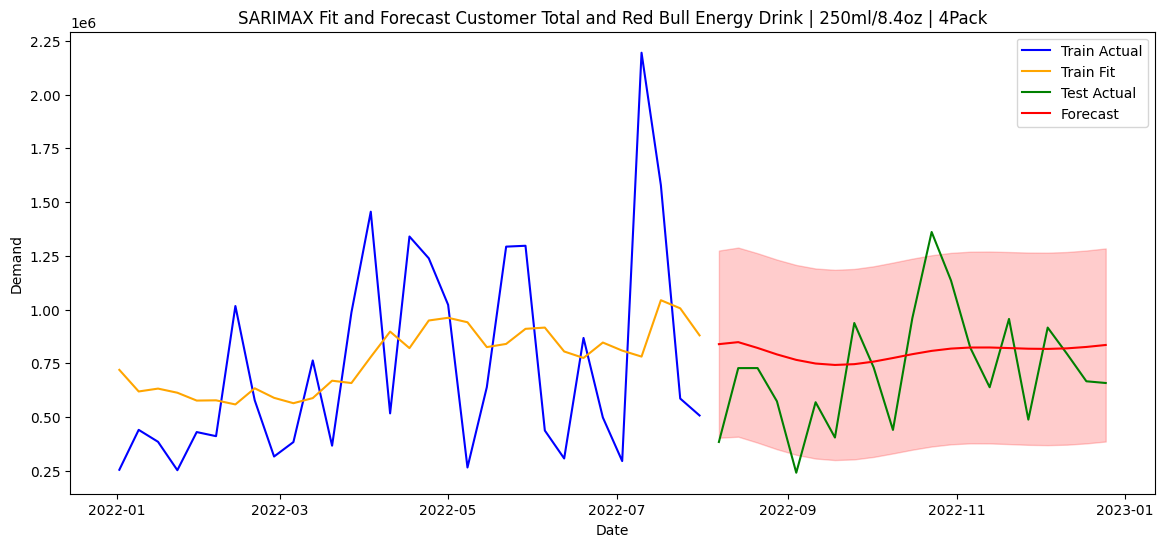

In [83]:
result = fit_dynamic_regression(
    df=df_weekly,                              # your full dataframe
    train_period=("2018-01-01", "2022-07-31"),
    val_period=("2022-08-01", "2022-12-31"),
    product_id="Red Bull Energy Drink | 250ml/8.4oz | 4Pack",
    customer="Customer Total",

    **best_params,

    y_transform=None,                   # or "log"
    ci_level=0.80                       # 80% CI
)

# Plot
plot_sarimax_fit_forecast(
    sarimax_fit=result["model_fit"], 
    y_train=result["y_train"], 
    y_val=result["y_val"],
    product_id=result["product_id"],
    customer=result["customer"], 
    X_train=result["X_train"].drop(columns=["week_number"]).astype(float), 
    X_val=result["X_val"].drop(columns=["week_number"]).astype(float),
    start_date="2022-01-01",
    alpha=0.2
)